In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("9000plus (2).csv")
df.head()

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url,user_id,rating
0,12/15/2021,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...,187,4.2
1,3/1/2022,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...,494,3.2
2,2/25/2022,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...,475,3.3
3,11/24/2021,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...,295,4.2
4,12/22/2021,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...,351,3.5


In [7]:
# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Convert numeric columns safely
for c in ["Popularity", "Vote_Count", "Vote_Average", "user_id", "rating"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Dates
if "Release_Date" in df.columns:
    df["Release_Date"] = pd.to_datetime(df["Release_Date"], errors="coerce")

# Fill missing text fields safely
if "Overview" in df.columns:
    df["Overview"] = df["Overview"].fillna("")
else:
    df["Overview"] = ""

if "Genre" in df.columns:
    df["Genre"] = (
        df["Genre"].fillna("")
          .astype(str)
          .str.replace("|", ",", regex=False)
          .str.strip()
    )
else:
    df["Genre"] = ""

if "Original_Language" in df.columns:
    df["Original_Language"] = df["Original_Language"].fillna("").astype(str).str.lower().str.strip()
else:
    df["Original_Language"] = ""

# Drop essential missing rows
df.dropna(subset=["Title", "user_id", "rating"], inplace=True)

# Standardize Title
df["Title"] = df["Title"].astype(str).str.strip()

#  keep ratings in range (if needed)
df = df[(df["rating"] >= 0) & (df["rating"] <= 5)]

# Reset index to avoid cosine matrix mismatch issues later
df = df.reset_index(drop=True)

df.shape


(9828, 11)

<h2>Popularity Based Recommendation</h2>

In [10]:
# Fill vote columns
df["Vote_Count"] = df["Vote_Count"].fillna(0)
df["Vote_Average"] = df["Vote_Average"].fillna(0)

C = df["Vote_Average"].mean()
m = df["Vote_Count"].quantile(0.75)

def weighted_rating(row, m=m, C=C):
    v = row["Vote_Count"]
    R = row["Vote_Average"]
    if (v + m) == 0:
        return C
    return (v / (v + m)) * R + (m / (v + m)) * C

df["popularity_score"] = df.apply(weighted_rating, axis=1)

df[["Title", "Vote_Count", "Vote_Average", "popularity_score"]].head()

,Title,Vote_Count,Vote_Average,popularity_score
0,Spider-Man: No Way Home,8940.0,8.3,8.051739
1,The Batman,1151.0,8.1,7.195427
2,No Exit,122.0,6.3,6.427465
3,Encanto,5076.0,7.7,7.431020
4,The King's Man,1793.0,7.0,6.756309


In [12]:
def recommend_popularity(df_data, k=10):
    return (
        df_data.sort_values("popularity_score", ascending=False)
               [["Title", "Genre", "Vote_Average", "Vote_Count", "popularity_score"]]
               .drop_duplicates("Title")
               .head(k)
    )

recommend_popularity(df, 10)

,Title,Genre,Vote_Average,Vote_Count,popularity_score
657,The Shawshank Redemption,"Drama, Crime",8.7,20911.0,8.560391
609,The Godfather,"Drama, Crime",8.7,15614.0,8.516865
221,The Dark Knight,"Drama, Action, Crime, Thriller",8.5,26994.0,8.400026
1318,Schindler's List,"Drama, History, War",8.6,12474.0,8.385281
1313,Pulp Fiction,"Thriller, Crime",8.5,22733.0,8.382357
1069,Forrest Gump,"Comedy, Drama, Romance",8.5,22308.0,8.380246
419,The Lord of the Rings: The Return of the King,"Adventure, Fantasy, Action",8.5,19183.0,8.362043
1007,The Godfather: Part II,"Drama, Crime",8.6,9393.0,8.323850
380,Inception,"Action, Science Fiction, Adventure",8.4,31077.0,8.316844
731,The Green Mile,"Fantasy, Drama, Crime",8.5,13604.0,8.310664


In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

def precision_recall_hit_at_k_popularity(test_df, df_rank, k=10, threshold=4.0):
    relevant = set(test_df[test_df["rating"] >= threshold]["Title"].dropna().unique())

    recommended = (
        df_rank.sort_values("popularity_score", ascending=False)["Title"]
              .drop_duplicates()
              .head(k)
              .values
    )

    tp = len(set(recommended) & relevant)

    precision = tp / k
    recall = tp / len(relevant) if len(relevant) > 0 else 0
    hit = 1 if tp > 0 else 0

    return {"Precision@K": precision, "Recall@K": recall, "HitRate@K": hit}

precision_recall_hit_at_k_popularity(test_df, df, k=10, threshold=4.0)

{'Precision@K': 0.3, 'Recall@K': 0.015, 'HitRate@K': 1}

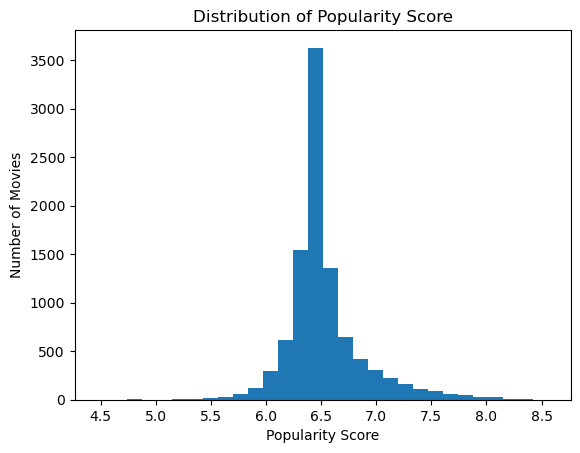

In [16]:
# Distribution
plt.figure()
plt.hist(df["popularity_score"].dropna(), bins=30)
plt.xlabel("Popularity Score")
plt.ylabel("Number of Movies")
plt.title("Distribution of Popularity Score")
plt.show()

# Top-10
top10_pop = recommend_popularity(df, 10)
plt.figure()
plt.barh(top10_pop["Title"], top10_pop["popularity_score"])
plt.xlabel("Popularity Score")
plt.ylabel("Movie Title")
plt.title("Top 10 Popular Movies")
plt.gca().invert_yaxis()
plt.show()

<h2>Content Based Recommendation
</h2>

In [21]:
def clean_text(x):
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df["Overview_clean"] = df["Overview"].apply(clean_text)
df["Genre_clean"] = df["Genre"].apply(clean_text)

# Weight genre more (repeat 3 times)
df["content"] = df["Overview_clean"] + " " + (df["Genre_clean"] + " ") * 3 + df["Original_Language"]
df[["Title", "content"]].head()


,Title,content
0,Spider-Man: No Way Home,peter parker is unmasked and no longer able to...
1,The Batman,in his second year of fighting crime batman un...
2,No Exit,stranded at a rest stop in the mountains durin...
3,Encanto,the tale of an extraordinary family the madrig...
4,The King's Man,as a collection of history s worst tyrants and...


In [23]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=15000,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = tfidf.fit_transform(df["content"])
cosine_sim_content = cosine_similarity(tfidf_matrix)

cosine_sim_content.shape


(9828, 9828)

In [25]:
df["Title_eval"] = df["Title"].astype(str).str.strip().str.lower()
title_to_index = pd.Series(df.index, index=df["Title_eval"]).groupby(level=0).first()

def recommend_similar_movies(title, df_data, cos_sim, title_index_map, k=10):
    key = str(title).strip().lower()
    if key not in title_index_map.index:
        return "Movie not found."

    idx = int(title_index_map.loc[key])

    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]

    movie_indices = [i for i, _ in sim_scores]
    out = df_data.loc[movie_indices, ["Title", "Genre", "Vote_Average"]].copy()
    out["similarity"] = [s for _, s in sim_scores]
    return out

# Test
recommend_similar_movies(df["Title"].iloc[0], df, cosine_sim_content, title_to_index, k=10)


,Title,Genre,Vote_Average,similarity
6486,The Marvels,"Action, Adventure, Science Fiction",0.0,0.552424
4338,Black Panther: Wakanda Forever,"Action, Adventure, Science Fiction",0.0,0.531711
144,Spider-Man: Far From Home,"Action, Adventure, Science Fiction",7.5,0.497703
3719,Stargate,"Action, Adventure, Science Fiction",7.0,0.495328
3323,Mad Max Beyond Thunderdome,"Action, Adventure, Science Fiction",6.2,0.494781
6667,Battle at Big Rock,"Adventure, Science Fiction, Action",7.1,0.483775
2277,Transformers: Revenge of the Fallen,"Science Fiction, Action, Adventure",6.1,0.482383
1245,Rogue One: A Star Wars Story,"Action, Adventure, Science Fiction",7.5,0.469674
9253,Godzilla vs. SpaceGodzilla,"Action, Adventure, Science Fiction",6.6,0.461031
76,Moonfall,"Action, Adventure, Science Fiction",5.9,0.458709


<h3>Content-Based Evaluation I: Leave-One-Out User Evaluation</h3>

In [29]:
def evaluate_content_leave_one_out(df_data, cos_sim, k=10, threshold=3.5, min_liked=2, seed=42):
    rng = np.random.default_rng(seed)
    users = df_data["user_id"].dropna().unique()

    hits, mrrs = [], []
    used_users = 0

    for u in users:
        liked_items = df_data.index[(df_data["user_id"] == u) & (df_data["rating"] >= threshold)].tolist()
        if len(liked_items) < min_liked:
            continue

        test_item = int(rng.choice(liked_items))
        train_liked = [i for i in liked_items if i != test_item]

        user_sim = cos_sim[train_liked].mean(axis=0)

        seen = set(df_data.index[df_data["user_id"] == u].tolist())
        if test_item in seen:
            seen.remove(test_item)

        ranked = np.argsort(-user_sim)

        recs = []
        for idx in ranked:
            if idx in seen:
                continue
            recs.append(idx)
            if len(recs) == k:
                break

        used_users += 1

        hit = 1 if test_item in recs else 0
        hits.append(hit)

        if hit:
            rank = recs.index(test_item) + 1
            mrrs.append(1 / rank)
        else:
            mrrs.append(0)

    hitrate = float(np.mean(hits)) if used_users else 0.0
    return {
        "Users evaluated": used_users,
        "HitRate@K": hitrate,
        "MRR@K": float(np.mean(mrrs)) if used_users else 0.0
    }

for K in [10, 20, 50]:
    print("K =", K, evaluate_content_leave_one_out(df, cosine_sim_content, k=K, threshold=3.5, min_liked=2))

K = 10 {'Users evaluated': 495, 'HitRate@K': 0.0, 'MRR@K': 0.0}
K = 20 {'Users evaluated': 495, 'HitRate@K': 0.0, 'MRR@K': 0.0}
K = 50 {'Users evaluated': 495, 'HitRate@K': 0.00404040404040404, 'MRR@K': 9.108306980647406e-05}


<h3>Content-Based Evaluation II: Genre-Based Item Similarity Evaluation</h3>

In [27]:
def top_k_recs_item(cosine_sim, i, k=10):
    scores = list(enumerate(cosine_sim[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    recs = [idx for idx, _ in scores[1:k+1]]
    return recs

def normalize_genres(s):
    if pd.isna(s):
        return set()
    parts = str(s).lower().replace("|", ",").split(",")
    return set([p.strip() for p in parts if p.strip()])

def evaluate_by_genre(df_data, cosine_sim, k=10):
    precisions, recalls, hits, mrrs = [], [], [], []
    evaluated = 0

    # precompute genres as sets
    genre_sets = df_data["Genre"].apply(normalize_genres)

    for i in range(len(df_data)):
        g_i = genre_sets.iloc[i]
        if len(g_i) == 0:
            continue

        recs = top_k_recs_item(cosine_sim, i, k=k)

        # relevant = movies sharing at least 1 genre with the query movie
        relevant = set(df_data.index[genre_sets.apply(lambda gs: len(gs & g_i) > 0)]) - {i}
        if len(relevant) == 0:
            continue

        rel_hits = [1 if r in relevant else 0 for r in recs]
        num_rel = sum(rel_hits)

        precisions.append(num_rel / k)
        recalls.append(num_rel / len(relevant))
        hits.append(1 if num_rel > 0 else 0)

        rr = 0
        for rank, r in enumerate(recs, start=1):
            if r in relevant:
                rr = 1 / rank
                break
        mrrs.append(rr)

        evaluated += 1

    return {
        "evaluated_items": evaluated,
        f"Precision@{k}": float(np.mean(precisions)) if evaluated else 0.0,
        f"Recall@{k}": float(np.mean(recalls)) if evaluated else 0.0,
        f"HitRate@{k}": float(np.mean(hits)) if evaluated else 0.0,
        "MRR": float(np.mean(mrrs)) if evaluated else 0.0
    }

for K in [5, 10, 20]:
    print("K =", K, evaluate_by_genre(df, cosine_sim_content, k=K))

K = 5 {'evaluated_items': 9826, 'Precision@5': 0.9938123346224303, 'Recall@5': 0.0017477466076461273, 'HitRate@5': 0.999898229187869, 'MRR': 0.9955254766266368}
K = 10 {'evaluated_items': 9826, 'Precision@10': 0.9944331365764298, 'Recall@10': 0.0034987495316763525, 'HitRate@10': 1.0, 'MRR': 0.9955424384286587}
K = 20 {'evaluated_items': 9826, 'Precision@20': 0.9947689802564624, 'Recall@20': 0.00700147993673064, 'HitRate@20': 1.0, 'MRR': 0.9955424384286587}


<h3>Personalized Content-Based Filtering Approach</h3>

In [67]:

def build_user_profile_vector(df_data, tfidf_matrix, user_id, threshold=3.5):
    """
    Creates a personalized user profile vector by averaging TF-IDF vectors of movies
    the user liked (rating >= threshold). Uses rating as a weight (optional but useful).
    Returns: (profile_vector, liked_indices)
    """
    user_rows = df_data[(df_data["user_id"] == user_id) & (df_data["rating"] >= threshold)]
    liked_indices = user_rows.index.to_list()

    if len(liked_indices) == 0:
        return None, []

    # weight by rating (optional)
    weights = user_rows["rating"].to_numpy()
    weights = weights / (weights.sum() + 1e-12)

    # weighted average of vectors (sparse-safe)
    profile = (tfidf_matrix[liked_indices].multiply(weights[:, None])).sum(axis=0)
    return profile, liked_indices


def recommend_personalized_content(
    df_data,
    tfidf_matrix,
    user_id,
    k=10,
    threshold=3.5,
    popularity_fallback=True
):
    """
    Recommends movies by comparing the user's profile vector to all movie vectors
    (cosine similarity). Excludes already seen items. Falls back to popularity for cold start.
    """
    # Cold start / no liked history
    profile, liked_indices = build_user_profile_vector(df_data, tfidf_matrix, user_id, threshold=threshold)
    if profile is None:
        if popularity_fallback and "popularity_score" in df_data.columns:
            return (
                df_data.sort_values("popularity_score", ascending=False)
                      [["Title", "Genre", "Vote_Average", "Vote_Count", "popularity_score"]]
                      .drop_duplicates("Title")
                      .head(k)
            )
        return "No user history found for this user_id."

    # Compute cosine similarity between user profile and all items:
    # cosine(u, M) = (M dot u) / (||M|| * ||u||)
    u = np.asarray(profile).ravel()
    u_norm = np.linalg.norm(u) + 1e-12

    # item norms
    item_norms = np.sqrt((tfidf_matrix.multiply(tfidf_matrix)).sum(axis=1)).A1 + 1e-12

    # dot products: (N x D) dot (D,) -> (N,)
    dots = tfidf_matrix @ u
    sims = np.asarray(dots).ravel() / (item_norms * u_norm)

    # Exclude seen items (all items this user has rated, not only liked)
    seen = set(df_data.index[df_data["user_id"] == user_id].to_list())
    sims[list(seen)] = -1  # push seen items to bottom

    # Top-K indices
    top_idx = np.argsort(-sims)[:k]

    out = df_data.loc[top_idx, ["Title", "Genre", "Vote_Average"]].copy()
    out["personalized_similarity"] = sims[top_idx]
    return out.reset_index(drop=True)

# Pick an existing user_id from your dataframe
example_user = df["user_id"].dropna().iloc[0]

recommend_personalized_content(
    df_data=df,
    tfidf_matrix=tfidf_matrix,
    user_id=example_user,
    k=10,
    threshold=3.5
)


,Title,Genre,Vote_Average,personalized_similarity
0,The Marvels,"Action, Adventure, Science Fiction",0.0,0.415125
1,Black Panther: Wakanda Forever,"Action, Adventure, Science Fiction",0.0,0.410606
2,Rogue One: A Star Wars Story,"Action, Adventure, Science Fiction",7.5,0.375512
3,Stargate,"Action, Adventure, Science Fiction",7.0,0.372220
4,Mad Max Beyond Thunderdome,"Action, Adventure, Science Fiction",6.2,0.371809
5,The Matrix Resurrections,"Science Fiction, Action, Adventure",6.8,0.354735
6,Godzilla vs. SpaceGodzilla,"Action, Adventure, Science Fiction",6.6,0.349116
7,Transformers: Revenge of the Fallen,"Science Fiction, Action, Adventure",6.1,0.348712
8,Star Wars: The Rise of Skywalker,"Action, Adventure, Science Fiction",6.4,0.347778
9,Iron Man 3,"Action, Adventure, Science Fiction",6.9,0.347666


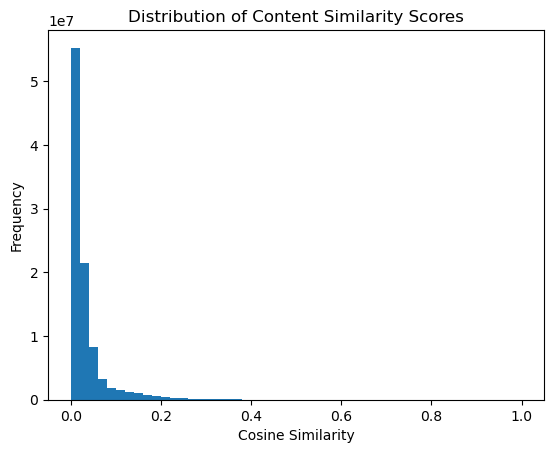

In [33]:
# Similarity distribution
plt.figure()
plt.hist(cosine_sim_content.flatten(), bins=50)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Content Similarity Scores")
plt.show()

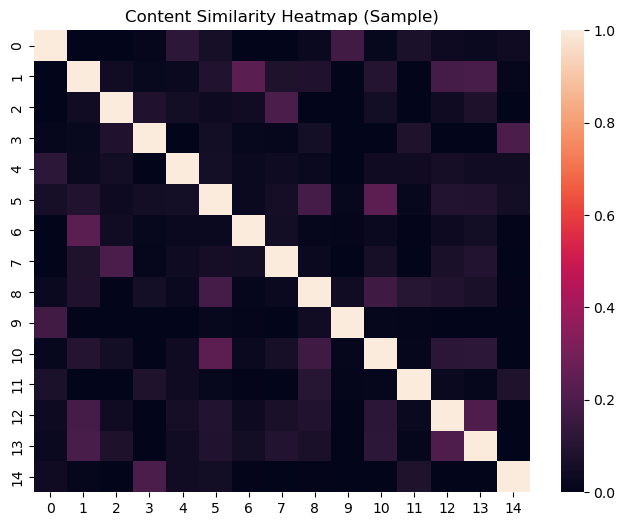

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_content[:15, :15])
plt.title("Content Similarity Heatmap (Sample)")
plt.show()

<h2>Collaborative Filtering Recommendation</h2>

In [38]:
# Create release year for unique movie_id
if "Release_Date" in df.columns:
    df["release_year"] = df["Release_Date"].dt.year.fillna(0).astype(int)
else:
    df["release_year"] = 0

df["movie_id"] = df["Title"].str.lower().str.strip() + "_" + df["release_year"].astype(str)

df[["Title", "release_year", "movie_id"]].head()

,Title,release_year,movie_id
0,Spider-Man: No Way Home,2021,spider-man: no way home_2021
1,The Batman,2022,the batman_2022
2,No Exit,2022,no exit_2022
3,Encanto,2021,encanto_2021
4,The King's Man,2021,the king's man_2021


In [40]:
user_item = df.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating",
    aggfunc="mean"
)

user_item_filled = user_item.fillna(0)

item_sim = cosine_similarity(user_item_filled.T)
item_sim_df = pd.DataFrame(item_sim, index=user_item_filled.columns, columns=user_item_filled.columns)

user_item_filled.shape, item_sim_df.shape

((500, 9821), (9821, 9821))

In [42]:
def recommend_cf(user_id, user_item_matrix, item_sim_df, k=10, min_rating=3.5):
    if user_id not in user_item_matrix.index:
        return None  # cold-start user

    user_ratings = user_item_matrix.loc[user_id].dropna()
    liked = user_ratings[user_ratings >= min_rating]

    if liked.empty:
        liked = user_ratings.sort_values(ascending=False).head(3)

    scores = pd.Series(0.0, index=item_sim_df.index)

    for movie, rating in liked.items():
        if movie in item_sim_df.columns:
            scores += item_sim_df[movie] * rating

    scores = scores.drop(index=user_ratings.index, errors="ignore")
    return scores.sort_values(ascending=False).head(k)

In [46]:
def eval_cf_leave_one_out_final(df_data, user_item_matrix, item_sim_df,
                               k=10, threshold=3.5, seed=42):
    rng = np.random.default_rng(seed)
    users = df_data["user_id"].dropna().unique()

    hits, mrrs, precisions, recalls = [], [], [], []
    used_users = 0

    for u in users:
        user_rows = df_data[
            (df_data["user_id"] == u) & (df_data["rating"] >= threshold)
        ]

        if user_rows["movie_id"].nunique() < 2:
            continue

        # Leave-one-out
        test_movie = rng.choice(user_rows["movie_id"].unique())
        train_rows = user_rows[user_rows["movie_id"] != test_movie]

        scores = pd.Series(0.0, index=item_sim_df.index)

        for _, row in train_rows.iterrows():
            mid = row["movie_id"]
            if mid in item_sim_df.columns:
                scores += item_sim_df[mid] * row["rating"]

        # Remove seen movies
        scores = scores.drop(index=train_rows["movie_id"].unique(), errors="ignore")

        recs = scores.sort_values(ascending=False).head(k).index.tolist()

        used_users += 1

        hit = 1 if test_movie in recs else 0
        hits.append(hit)

        # Precision@K and Recall@K (leave-one-out)
        precisions.append((1 / k) if hit else 0)
        recalls.append(1 if hit else 0)

        if hit:
            rank = recs.index(test_movie) + 1
            mrrs.append(1 / rank)
        else:
            mrrs.append(0)

    return {
        "Users evaluated": used_users,
        "Precision@K": float(np.mean(precisions)) if used_users else 0.0,
        "Recall@K": float(np.mean(recalls)) if used_users else 0.0,
        "HitRate@K": float(np.mean(hits)) if used_users else 0.0,
        "MRR@K": float(np.mean(mrrs)) if used_users else 0.0
    }


# Run evaluation
for K in [10, 20, 50]:
    print(
        "K =", K,
        eval_cf_leave_one_out_final(df, user_item, item_sim_df,
                                    k=K, threshold=3.5)
    )


K = 10 {'Users evaluated': 495, 'Precision@K': 0.07515151515151515, 'Recall@K': 0.7515151515151515, 'HitRate@K': 0.7515151515151515, 'MRR@K': 0.21786115119448451}
K = 20 {'Users evaluated': 495, 'Precision@K': 0.04989898989898991, 'Recall@K': 0.997979797979798, 'HitRate@K': 0.997979797979798, 'MRR@K': 0.23668087791434259}
K = 50 {'Users evaluated': 495, 'Precision@K': 0.019999999999999997, 'Recall@K': 1.0, 'HitRate@K': 1.0, 'MRR@K': 0.23677707801054268}


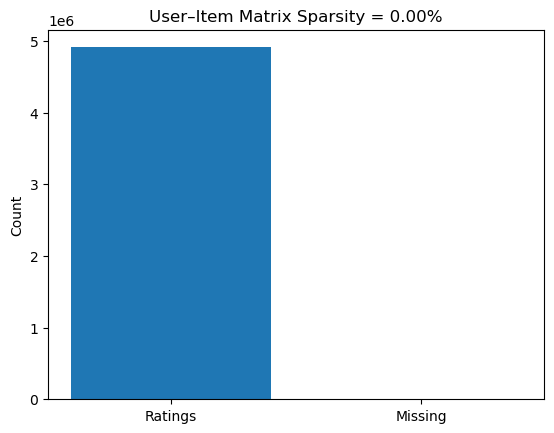

In [48]:
# Sparsity
num_ratings = np.count_nonzero(user_item.values)
total_entries = user_item.shape[0] * user_item.shape[1]
sparsity = 1 - (num_ratings / total_entries)

plt.figure()
plt.bar(["Ratings", "Missing"], [num_ratings, total_entries - num_ratings])
plt.title(f"User–Item Matrix Sparsity = {sparsity:.2%}")
plt.ylabel("Count")
plt.show()

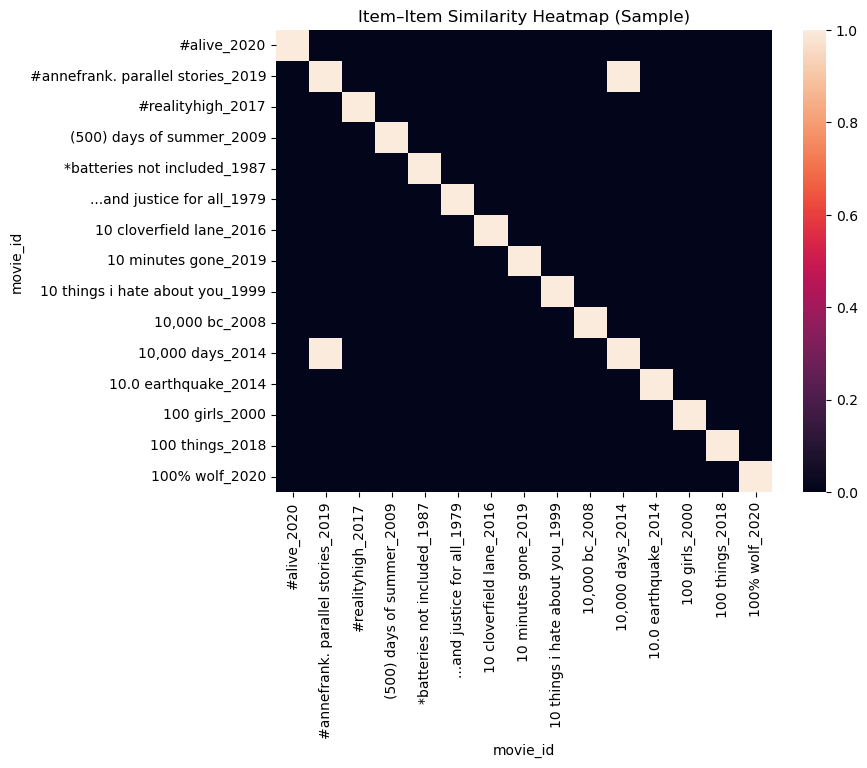

In [50]:
plt.figure(figsize=(8,6))
sns.heatmap(item_sim_df.iloc[:15, :15])
plt.title("Item–Item Similarity Heatmap (Sample)")
plt.show()

<h2>RMSE (RATING PREDICTION) - Collaborative Filtering</h2>

In [53]:
def rmse(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# Use interaction split for RMSE
train_int, test_int = train_test_split(df[["user_id", "movie_id", "rating"]], test_size=0.2, random_state=42)

# Train user-item matrix
train_ui = train_int.pivot_table(index="user_id", columns="movie_id", values="rating", aggfunc="mean")

# Fill 0 for similarity computation only
train_ui_filled = train_ui.fillna(0)

train_item_sim = cosine_similarity(train_ui_filled.T)
train_item_sim_df = pd.DataFrame(train_item_sim, index=train_ui_filled.columns, columns=train_ui_filled.columns)

global_mean = train_int["rating"].mean()

def predict_rating_item_cf(user_id, movie_id, train_ui, item_sim_df, topn=20):
    if user_id not in train_ui.index:
        return np.nan
    if movie_id not in item_sim_df.columns:
        return np.nan

    user_ratings = train_ui.loc[user_id].dropna()
    if user_ratings.empty:
        return np.nan

    rated_items = user_ratings.index
    sims = item_sim_df.loc[movie_id, rated_items].sort_values(ascending=False).head(topn)

    if sims.sum() == 0:
        return np.nan

    num = (sims.values * user_ratings[sims.index].values).sum()
    den = np.abs(sims.values).sum()
    return float(num / den) if den != 0 else np.nan

y_true, y_pred = [], []
for row in test_int.itertuples(index=False):
    u, m, r = row.user_id, row.movie_id, row.rating
    pred = predict_rating_item_cf(u, m, train_ui, train_item_sim_df, topn=20)

    # Cold-start fallback for RMSE: use global mean rating
    if np.isnan(pred):
        pred = global_mean

    y_true.append(r)
    y_pred.append(pred)

cf_rmse = rmse(y_true, y_pred)
print("\nCollaborative Filtering RMSE (prediction):", cf_rmse)


Collaborative Filtering RMSE (prediction): 0.6038372306116382


<h3>Cold Start (New User)</h3>

In [56]:
def recommend_for_user_final(user_id, k=10):
    # Cold-start user: no history
    if user_id not in user_item.index:
        print("Cold-start user detected → showing Popularity-based recommendations.")
        return recommend_popularity(df, k)

    recs = recommend_cf(user_id, user_item, item_sim_df, k=k, min_rating=3.5)
    if recs is None or len(recs) == 0:
        print("No CF recommendations → fallback to Popularity-based.")
        return recommend_popularity(df, k)

    return recs

In [58]:
display(recommend_for_user_final(999999, 10))

Cold-start user detected → showing Popularity-based recommendations.


,Title,Genre,Vote_Average,Vote_Count,popularity_score
657,The Shawshank Redemption,"Drama, Crime",8.7,20911.0,8.560391
609,The Godfather,"Drama, Crime",8.7,15614.0,8.516865
221,The Dark Knight,"Drama, Action, Crime, Thriller",8.5,26994.0,8.400026
1318,Schindler's List,"Drama, History, War",8.6,12474.0,8.385281
1313,Pulp Fiction,"Thriller, Crime",8.5,22733.0,8.382357
1069,Forrest Gump,"Comedy, Drama, Romance",8.5,22308.0,8.380246
419,The Lord of the Rings: The Return of the King,"Adventure, Fantasy, Action",8.5,19183.0,8.362043
1007,The Godfather: Part II,"Drama, Crime",8.6,9393.0,8.323850
380,Inception,"Action, Science Fiction, Adventure",8.4,31077.0,8.316844
731,The Green Mile,"Fantasy, Drama, Crime",8.5,13604.0,8.310664


<h3>User Input</h3>

In [61]:
def interactive_popularity(k=10):
    display(recommend_popularity(df, k))

def interactive_content(k=10):
    title = input("Enter a movie title: ").strip().lower()

    all_titles = df["Title"].str.lower().tolist()

    if title not in all_titles:
        print("Movie not found. Try one of these:")
        print(df["Title"].sample(5).tolist())
        return

    display(recommend_similar_movies(title, df, cosine_sim_content, title_to_index, k=k))


def interactive_collaborative(k=10):
    try:
        user_id = int(input("Enter user ID: "))
    except:
        print("Invalid user ID.")
        return

    recs = recommend_cf(user_id, user_item, item_sim_df, k=k)

    if recs is None or len(recs) == 0:
        print("Cold-start user or no recommendations. Showing popularity-based results.")
        display(recommend_popularity(df, k))
        return

  
   

    display(recs.reset_index().rename(columns={"index": "movie_id", 0: "score"}))

In [63]:
def recommender_menu():
    print("1. Popularity-based Recommendation")
    print("2. Content-based Recommendation")
    print("3. Collaborative Filtering Recommendation")

    choice = input("Enter your choice (1/2/3): ").strip()

    if choice == "1":
        interactive_popularity(k=10)

    elif choice == "2":
        interactive_content(k=10)

    elif choice == "3":
        interactive_collaborative(k=10)

    else:
        print("Invalid choice.")

In [71]:
recommender_menu()

1. Popularity-based Recommendation
2. Content-based Recommendation
3. Collaborative Filtering Recommendation


Enter your choice (1/2/3):  3
Enter user ID:  3


,movie_id,score
0,#alive_2020,0.0
1,sharknado_2013,0.0
2,shark bait_2006,0.0
3,shark beach with chris hemsworth_2021,0.0
4,shark night 3d_2011,0.0
5,shark tale_2004,0.0
6,sharkdog’s fintastic halloween_2021,0.0
7,sharknado 3: oh hell no!_2015,0.0
8,sharknado 5: global swarming_2017,0.0
9,sharpay's fabulous adventure_2011,0.0
